In [12]:
%load_ext autoreload
%autoreload 2

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../'))  # return the projest's root folder
sys.path.append(project_root)
from utils import multiple_split, load_parameters, split_helper, restrict_group_samples, lgb_optimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

random_seed = 42
np.random.seed(random_seed)

In [14]:
# load the parameters from file ---------------------------------------------------------
params = load_parameters('parameters.yaml')

dataset: nasa
features: ['voltage', 'temperature', 'discharge_voltage_rate']
labels: ['capacity']
data_groupby: ['cycle', 'capacity']
num_trials: 500
overlap_mode: all
split_size: 20
multi_split_size: [5, 10, 15, 20, 40, 50, 70, 100]
num_restricted: 20


In [15]:
# data read path
folder_path = f'data_{params.dataset}/'

# data save path 
model_save_path = f'model_{params.dataset}/'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

In [16]:
# read the data
path_dict = {'train': f'{folder_path}train_processed.csv',
             'valid': f'{folder_path}train_processed.csv',
             'test': f'{folder_path}test_processed_first{params.num_restricted}.csv',
            #  'test': f'{folder_path}test_processed.csv'
             }
data_dict = {key: pd.read_csv(path, index_col=0) for key, path in path_dict.items()}

train,valid,test = data_dict['train'], data_dict['valid'], data_dict['test']

# get the training data and validating data
x = train[params.features]
y = train[params.labels].squeeze()
vx = valid[params.features]
vy = valid[params.labels].squeeze()

# get the test data
test_x = test[params.features]
test_y = test[params.labels]

In [17]:
# find the best hyperparameters of lightgbm model
study_nasa = optuna.create_study(direction="minimize")
study_nasa.optimize(lambda trial: lgb_optimize(trial, x, y, vx, vy), n_trials=params.num_trials, n_jobs=-1, show_progress_bar=True)
best_hyperparameters = study_nasa.best_params
print(f"Best hyperparameters: {best_hyperparameters}")

# fit the model using the combination of training data and validation data
best_model = lgb.LGBMRegressor(**best_hyperparameters)
best_model.fit(pd.concat([x,vx]), pd.concat([y,vy]))

Best trial: 482. Best value: 0.0163417: 100%|██████████| 500/500 [03:02<00:00,  2.73it/s]


Best hyperparameters: {'learning_rate': 0.26006913594659103, 'max_depth': 18, 'num_leaves': 35, 'min_child_samples': 2, 'subsample': 0.694657636798936, 'colsample_bytree': 0.9077323002177208, 'reg_alpha': 0.03221624057796291, 'reg_lambda': 8.043082895907286, 'n_estimators': 442}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 44484, number of used features: 3
[LightGBM] [Info] Start training from score 1.573092


LGBMRegressor(colsample_bytree=0.9077323002177208,
              learning_rate=0.26006913594659103, max_depth=18,
              min_child_samples=2, n_estimators=442, num_leaves=35,
              reg_alpha=0.03221624057796291, reg_lambda=8.043082895907286,
              subsample=0.694657636798936)

In [18]:
# test the model
pred = best_model.predict(test_x)
mae = mean_absolute_error(test_y, pred)
print("mae on the test set:", mae)

mae on the test set: 0.01886499629823821


In [19]:
# save the model
model_name = f'{model_save_path}nasa_{len(params.features)}features_first{params.num_restricted}_{str(f"{mae:.8f}".split(".")[1])}.pkl'
with open(model_name, 'wb') as f:
    pickle.dump(best_model, f)
print(f'already saved into {model_name}')

already saved into model_nasa/nasa_3features_first20_01886500.pkl


In [20]:
# with open('model_nasa/nasa_16features_first50_01541958.pkl', 'rb') as file:
#     best_model = pickle.load(file)
# pred = best_model.predict(test_x)
# mae = mean_absolute_error(test_y, pred)
# print("mae on the test set:", mae)

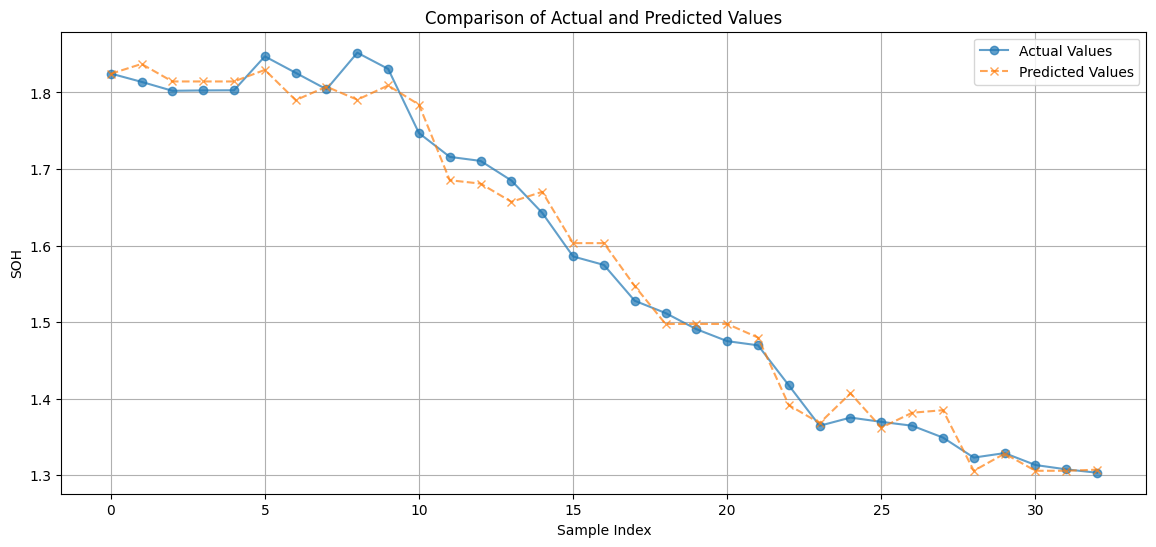

In [21]:
actual_values = test_y
predicted_values = pred
plt.figure(figsize=(14,6))
plt.plot(actual_values.reset_index(drop=True), label='Actual Values', linestyle='-', marker='o', alpha=0.7)
plt.plot(predicted_values, label='Predicted Values', linestyle='--', marker='x', alpha=0.7)
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('SOH')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Get feature importance
importances = best_model.feature_importances_

# Combine feature names and importance values
feature_importance_pairs = list(zip(params.features, importances))

# Sort by importance values in descending order
sorted_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print the sorted results
for feature, importance in sorted_pairs:
    print(f"{feature}: {importance:.1f}")

discharge_voltage_rate: 5433.0
voltage: 5031.0
temperature: 4564.0
